# AI Agent for Insurance News & Reports Digest

This agent aims at obtaining news and reports digest updates from various areas related with insurance such as climate risk, policies, risk management, insurtech, etc. 
It takes in a topic or a news vertical as an input, to start generating the most relevant and the latest news and report updates. This is reflected on a Streamlit dashboard.
Currently only two topics have been focused - climate risk and insurtech.

**Tools/Packages used** :

* Google custom search API - to search relevant results
* ScrapingBee third-party service - To scrape contents from news / report sites
* Langgraph - To build an ReAct agent
* Langchain's google-genai - To utilize Gemini's Flash model
* Streamlit for UI

**Models used**:

* Central LLM used for the agent - Gemini 2.0 Flash
* LLM used for query constructing - Gemini 2.0 Flash
* LLM for collating the final results ready to render - Gemma-3 27B IT

In [1]:
!pip install uv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 74.6 MB/s eta 0:00:00:00:0100:01


In [1]:
!uv pip install langgraph==0.3.30 langchain-google-genai==2.1.2 langchain-openai feedparser==6.0.11 scrapingbee==2.0.1 streamlit --system

Using Python 3.11.11 environment at: /usr
Resolved 93 packages in 1.70s                                        
   Building sgmllib3k==1.0.0                                           
   Building sgmllib3k==1.0.0                                   
⠙ Preparing packages... (0/16)
   Building sgmllib3k==1.0.0     0 B/19.50 KiB                     
⠙ Preparing packages... (0/16)
   Building sgmllib3k==1.0.0 14.87 KiB/19.50 KiB                   
⠙ Preparing packages... (0/16)
filetype   ------------------------------ 14.87 KiB/19.50 KiB
   Building sgmllib3k==1.0.0     0 B/46.14 KiB                  
⠙ Preparing packages... (0/16)
filetype   ------------------------------ 14.87 KiB/19.50 KiB
   Building sgmllib3k==1.0.0 14.94 KiB/46.14 KiB                
⠙ Preparing packages... (0/16)
filetype   ------------------------------ 14.87 KiB/19.50 KiB
langgraph-sdk ------------------------------ 14.94 KiB/46.14 KiB
   Building sgmllib3k==1.0.0     0 B/6.58 MiB                      
⠙ Preparing 

In [2]:
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.prebuilt import create_react_agent
from langchain_core.tools import tool
from langchain.prompts import PromptTemplate
from langchain_core.prompts import ChatPromptTemplate
from langgraph.checkpoint.memory import MemorySaver

from pydantic import BaseModel
from typing import List, Dict, Optional,Any

from datetime import date
import datetime
import logging
import json
from datetime import datetime, timezone
import requests
import re

from scrapingbee import ScrapingBeeClient
import googleapiclient.discovery
import dateutil.parser
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import feedparser
import urllib.robotparser
import time
from urllib.parse import urlparse
from dateutil.parser import parse as dateutil_parse

In [3]:
logging.basicConfig(level=logging.INFO)

In [4]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()

openrouter_api_key = user_secrets.get_secret("OPENROUTER_API_KEY")
gemini_api_key = user_secrets.get_secret("GOOGLE_API_KEY")
gsearch_api_key = user_secrets.get_secret("google_search_api_key_2")
gsearch_engine_id = user_secrets.get_secret("google_search_engine_id_2")
sb_api_key = user_secrets.get_secret("scraping_bee_api_key")

In [24]:
# Initialize Gemini model
llm = ChatGoogleGenerativeAI(
    model = "gemini-2.0-flash",
    google_api_key=gemini_api_key,
    temperature=0.7)

In [6]:
class QueryResults(BaseModel):
    topic: str
    news_queries: List[str]
    report_queries: List[str]

class SearchResults(BaseModel):
    topic: str
    news_searches: Optional[List[Dict[str, str]]] = None
    report_searches: Optional[List[Dict[str, str]]] = None

In [7]:
# Add tools

@tool
def query_builder(topic: str) -> str:
    '''This tool builds a set of queries used to retrieve relevant results for a given topic.'''

    
    year = date.today().strftime("%Y")

    template = """Generate 3 search queries suitable to be input to Google custom search API. The purpose is to retrieve the most relevant search results related to 
    the insurance sector in connection to a given {topic}. One set of search results should contain relevant news and also be very focused only around the {topic}. Other set
    of search results should contain relevant information about report updates and also be very focused around {topic}. Be innovative and creative in creating the best search 
    queries. Each query must be unique and tailored results that are globally generic.Be sure to pass the year 2025 as a part of each query. Also add keywords meaning 
    "latest" or "most recent" to keep the results the most recent. Do not use quotes/special symbols within the query. The last query for both relevant news and relevant reports 
    must be PREFIXED by "inurl:(/rss | /feed | /atom)". Do not replace "null" with None in the final output.
    Output Format:
    {topic} :
    news_queries : [query1, query2, query3]
    report_queries : [query1, query2, query3]
    """

    prompt = PromptTemplate(
        input_variables = ['topic'],
        template=template
    )
    
    formatted_prompt = prompt.format(topic=topic)

    # Define the LLM

    int_mod = "gemini-2.0-flash"

    llm = ChatGoogleGenerativeAI(
    model=int_mod,
    google_api_key=gemini_api_key,
    temperature=0.9)

    model_with_structure = llm.with_structured_output(QueryResults)
    
    # Invoke the model to produce structured output that matches the schema
    query_results = model_with_structure.invoke(input=formatted_prompt)
    #output = llm.invoke(input=formatted_prompt)

    #return {'query_results' : query_results}
    print(type(query_results.model_dump_json))
    return query_results.model_dump_json()

In [8]:
@tool
def get_search_results(query_results: str) -> str:
    """Retrieve search results, extracting any valid date and returning year on failure."""
    query_results = QueryResults.model_validate_json(query_results)
    print("query_results entered func search_results")

    results_dict = {}
    query_results = json.loads(query_results.model_dump_json())
    query_categories = [('news_queries', 'news_searches'), ('report_queries', 'report_searches')]

    # Initialize Google Custom Search API
    service = googleapiclient.discovery.build('customsearch', 'v1', developerKey=gsearch_api_key)

    # Regular expressions for extracting dates (e.g., "2024-11-01", "Feb 5, 2025")
    date_patterns = [
    r'\b(\d{4})[-/\.](0[1-9]|1[0-2])[-/\.](0[1-9]|[12]\d|3[01])\b',  # Matches: 2024-11-01, 2025/11/01
    r'\b(0[1-9]|[12]\d|3[01])[-/\.](0[1-9]|1[0-2])[-/\.](\d{4})\b',  # Matches: 01-11-2024, 01/11/2025
    r'\b(0[1-9]|[12]\d|3[01])\s+(january|february|march|april|may|june|july|august|september|october|november|december)\s+(\d{4})\b',  # Matches: 01 November 2024
    r'\b(january|february|march|april|may|june|july|august|september|october|november|december)\s+(0[1-9]|[12]\d|3[01])\s*,?\s*(\d{4})\b',  # Matches: November 01, 2024
    r'\b(0[1-9]|[12]\d|3[01])(st|nd|rd|th)?\s+(jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)\s+(\d{4})\b',  # Matches: 5th Feb 2025
    r'\b(jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)\s+(0[1-9]|[12]\d|3[01])(st|nd|rd|th)?\s*,?\s*(\d{4})\b',  # Matches: Feb 5, 2025
    r'\b(january|february|march|april|may|june|july|august|september|october|november|december)\s+\d{4}\b',  # Matches: February 2025
    r'\b\d{4}\s+(january|february|march|april|may|june|july|august|september|october|november|december)\b',  # Matches: 2025 February
    r'\b\d{4}\b',  # Matches: 2025 (fallback)
]

    def get_published_date(item):
        """Extract date from snippet, title, link, or metadata; return year if date parsing fails."""
        today = datetime.now(timezone.utc).date()
        month_map = {
            'january': '01', 'february': '02', 'march': '03', 'april': '04', 'may': '05', 'june': '06',
            'july': '07', 'august': '08', 'september': '09', 'october': '10', 'november': '11', 'december': '12',
            'jan': '01', 'feb': '02', 'mar': '03', 'apr': '04', 'may': '05', 'jun': '06',
            'jul': '07', 'aug': '08', 'sep': '09', 'oct': '10', 'nov': '11', 'dec': '12'
        }

        # Step 1: Check snippet for explicit date
        snippet = item.get('snippet', '')
        for pattern in date_patterns:
            match = re.search(pattern, snippet, re.IGNORECASE)
            if match:
                date_str = match.group(0)
                try:
                    parsed_date = dateutil_parse(date_str, fuzzy=False, dayfirst=False)
                    if parsed_date.tzinfo is None:
                        parsed_date = parsed_date.replace(tzinfo=timezone.utc)
                    # Handle incomplete dates
                    if pattern == date_patterns[-1]:  # Year only
                        return match.group(0)  # Return year (e.g., "2025")
                    elif pattern in date_patterns[6:8]:  # Month-year
                        year = match.groups()[-1]
                        month = month_map[match.groups()[0].lower() or match.groups()[1].lower()]
                        return f"{year}-{month}-01"
                    # Reject today's date
                    if parsed_date.date() == today and not today.strftime('%Y-%m-%d') in snippet:
                        print(f"Debug: Rejected today’s date {parsed_date} from snippet for {item['link']}")
                        continue
                    print(f"Debug: Found date {parsed_date} in snippet for {item['link']}")
                    return parsed_date
                except (ValueError, TypeError) as e:
                    print(f"Debug: Failed to parse {date_str} from snippet for {item['link']}: {e}")
                    if pattern == date_patterns[-1]:  # Year only
                        return match.group(0)  # Return year on parsing failure

        # Step 2: Check metadata from pagemap.metatags
        if 'pagemap' in item and 'metatags' in item['pagemap'] and item['pagemap']['metatags']:
            metatags = item['pagemap']['metatags'][0]
            date_keys = ['article:published_time', 'og:published_time', 'pubdate', 'date', 'timestamp']
            for key in date_keys:
                if key in metatags:
                    date_str = metatags[key]
                    try:
                        parsed_date = dateutil_parse(date_str, fuzzy=False, dayfirst=False)
                        if parsed_date.tzinfo is None:
                            parsed_date = parsed_date.replace(tzinfo=timezone.utc)
                        if parsed_date.date() == today and not any(
                            today.strftime('%Y-%m-%d') in s for s in [snippet, item.get('title', '')]
                        ):
                            print(f"Debug: Rejected today’s date {parsed_date} from metadata for {item['link']}")
                            continue
                        print(f"Debug: Found date {parsed_date} in metadata for {item['link']}")
                        return parsed_date
                    except (ValueError, TypeError) as e:
                        print(f"Debug: Failed to parse {key}={date_str} for {item['link']}: {e}")

        # Step 3: Check title and link for date patterns
        text_sources = [item.get('title', ''), item.get('link', '')]
        combined_text = ' '.join(text_sources)
        for pattern in date_patterns:
            match = re.search(pattern, combined_text, re.IGNORECASE)
            if match:
                date_str = match.group(0)
                try:
                    parsed_date = dateutil_parse(date_str, fuzzy=False, dayfirst=False)
                    if parsed_date.tzinfo is None:
                        parsed_date = parsed_date.replace(tzinfo=timezone.utc)
                    if pattern == date_patterns[-1]:  # Year only
                        return match.group(0)  # Return year
                    elif pattern in date_patterns[6:8]:  # Month-year
                        year = match.groups()[-1]
                        month = month_map[match.groups()[0].lower() or match.groups()[1].lower()]
                        return f"{year}-{month}-01"
                    if parsed_date.date() == today and not today.strftime('%Y-%m-%d') in combined_text:
                        print(f"Debug: Rejected today’s date {parsed_date} from title/link for {item['link']}")
                        continue
                    print(f"Debug: Found date {parsed_date} in title/link for {item['link']}")
                    return parsed_date
                except (ValueError, TypeError) as e:
                    print(f"Debug: Failed to parse {date_str} from title/link for {item['link']}: {e}")
                    if pattern == date_patterns[-1]:  # Year only
                        return match.group(0)  # Return year on parsing failure

        # Step 4: Fallback to year from snippet, title, or link
        combined_text_lower = (snippet + ' ' + combined_text).lower()
        for year in ['2023', '2024', '2025']:
            if year in combined_text_lower:
                print(f"Debug: Found year {year} in combined text for {item['link']}")
                return year

        # Step 5: Default to year of threshold
        print(f"Debug: No valid date or year found for {item['link']}, defaulting to 2024")
        return None

    for category in query_categories:
        print("category", category)
        queries = query_results[category[0]]
        all_items = []

        # Step 1: Retrieve search results
        if queries:
            for query in queries:
                response = service.cse().list(q=query, cx=gsearch_engine_id, num=6).execute()
                items = response.get('items', [])
                all_items.extend(items)
            #print("done 1")

            # Step 2: Remove duplicates
            seen_links = set()
            unique_items = [item for item in all_items if item['link'] not in seen_links and not seen_links.add(item['link'])]
            #print("done 2")

            # Step 3: Filter by published date (>= Sep 2024)
            threshold = datetime(2024, 9, 1, tzinfo=timezone.utc)
            filtered_items = []

            for item in unique_items:
                published_date = get_published_date(item)
                if published_date:
                    if isinstance(published_date, datetime):
                        if published_date >= threshold:
                            filtered_items.append({
                                'title': item['title'],
                                'link': item['link'],
                                'snippet': item['snippet'],
                                'doc_type': item.get('fileFormat', 'text/html'),
                                'published_date': published_date.isoformat()
                            })
                    elif isinstance(published_date, str):
                        # Handle year-only or year-month strings
                        if len(published_date) == 4 and int(published_date) >= 2024:  # Year only
                            filtered_items.append({
                                'title': item['title'],
                                'link': item['link'],
                                'snippet': item['snippet'],
                                'doc_type': item.get('fileFormat', 'text/html'),
                                'published_date': f"{published_date}-01-01"
                            })
                        elif published_date >= '2024-09-01':  # Year-month
                            filtered_items.append({
                                'title': item['title'],
                                'link': item['link'],
                                'snippet': item['snippet'],
                                'doc_type': item.get('fileFormat', 'text/html'),
                                'published_date': published_date
                            })

            # Step 4: Sort by published date (descending)
            def sort_key(item):
                date_str = item['published_date']
                if len(date_str) == 4:  # Year only
                    return (int(date_str), 12, 31)
                elif len(date_str) == 7:  # Year-month
                    year, month = map(int, date_str.split('-'))
                    return (year, month, 31)
                dt = dateutil_parse(date_str)
                return (dt.year, dt.month, dt.day)

            sorted_items = sorted(filtered_items, key=sort_key, reverse=True)
            top_7 = sorted_items[:7]
            results_dict[category[1]] = top_7
            #print("done 4")
        else:
            results_dict[category[1]] = []

    results_dict['topic'] = query_results['topic']
    #print("results_dict>>>>", results_dict)

    with open("get_search_results.json", 'w') as f:
        json.dump(results_dict, f, indent=2)

    #print("Done")
    search_results = SearchResults(**results_dict)
    #print("fin done")
    return search_results.model_dump_json()

In [9]:
@tool
def scrape_content(search_results: str):
    """This function tool scrapes the full content ( news/reports) from the links provided as input from get_search_result"""
    
    # ScrapingBee API key
    SCRAPINGBEE_API_KEY = sb_api_key
    SCRAPINGBEE_URL = 'https://app.scrapingbee.com/api/v1/'
    USER_AGENT = 'Chrome'  
    REQUEST_DELAY = 2  # Delay in seconds between requests

    search_results = SearchResults.model_validate_json(search_results)

    #print("I'm inside scrape_content")

    search_results = search_results.model_dump_json()
    #print(type(search_results))

    search_results = json.loads(search_results)
    
    #print("deep inside scrape_content")
    #print(json.dumps(search_results, indent=2))

    
    def check_robots_txt(url):
        """Check if scraping is allowed by robots.txt."""
        try:
            rp = urllib.robotparser.RobotFileParser()
            parsed_url = urlparse(url)
            robots_url = f"{parsed_url.scheme}://{parsed_url.netloc}/robots.txt"
            rp.set_url(robots_url)
            rp.read()
            return rp.can_fetch(USER_AGENT, url)
        except Exception as e:
            print(f"Error checking robots.txt for {url}: {e}")
            return True  # Default to allowing if robots.txt is inaccessible
    
    def check_terms_of_service(soup):
        """Check for anti-scraping terms in page content."""
        keywords = ['no scraping', 'prohibited', 'unauthorized access', 'terms of service']
        text = soup.get_text().lower()
        for keyword in keywords:
            if keyword in text:
                return False
        return True
    
    def scrape_page(url):
        """Scrape the full page content using ScrapingBee."""
        params = {
            #'api_key': SCRAPINGBEE_API_KEY,
            #'url': url,
            'render_js': 'false',  # Disabled to reduce cost
            'premium_proxy': 'false',  # Disabled to reduce cost
            'timeout': 30000,
            #'custom_headers': json.dumps({'User-Agent': USER_AGENT}),
        }
        
        try:
            #from scrapingbee import ScrapingBeeClient
#url = "https://www.globenewswire.com/news-release/2025/04/18/3064029/28124/en/Insurtech-Market-Boom-2025-Set-for-Explosive-36-CAGR-Reaching-133-Billion-by-2034-Digital-Transformation-Fueling-Industry-Growth-with-Brokers-Agents-Remaining-Key-Players.html"

            client = ScrapingBeeClient(api_key=sb_api_key)
            response = client.get(url,params=params)
            return response.text

            #response = requests.get(SCRAPINGBEE_URL, params=params)
            #response.raise_for_status()
            return response.text
        except requests.RequestException as e:
            print(f"Error scraping {url}: {e}")
            return None
    
    def extract_date_from_content(soup):
        """Extract date from page content using common patterns."""
        date_patterns = [
            r'\b(?:January|February|March|April|May|June|July|August|September|October|November|December)\s+\d{1,2},\s+\d{4}\b',
            r'\b\d{1,2}/\d{1,2}/\d{4}\b',
            r'\b\d{4}-\d{2}-\d{2}\b',
        ]
        
        text = soup.get_text()
        for pattern in date_patterns:
            match = re.search(pattern, text)
            if match:
                try:
                    date_str = match.group(0)
                    return datetime.strptime(date_str, '%B %d, %Y').strftime('%Y-%m-%d') if ',' in date_str else date_str
                except ValueError:
                    continue
        return None
    
    def find_rss_feeds(soup, base_url):
        """Find and parse RSS feeds from the page."""
        rss_feeds = []
        rss_links = soup.find_all('link', type='application/rss+xml')
        
        for rss in rss_links:
            rss_url = rss.get('href')
            if rss_url and not rss_url.startswith('http'):
                rss_url = base_url + rss_url if base_url.endswith('/') else base_url + '/' + rss_url
            
            try:
                feed = feedparser.parse(rss_url)
                for entry in feed.entries[:4]:  # Limit to 4 entries
                    feed_data = {
                        'rss_title': entry.get('title', ''),
                        'rss_link': entry.get('link', ''),
                        'rss_published': entry.get('published', '') or entry.get('updated', ''),
                        'rss_summary': entry.get('summary', ''),
                        'rss_full_content': entry.get('content', [{}])[0].get('value', '') if entry.get('content') else entry.get('summary', ''),
                    }
                    rss_feeds.append(feed_data)
            except Exception as e:
                print(f"Error parsing RSS feed {rss_url}: {e}")
        
        return rss_feeds
    
    def process_item(item):
        """Process a single item (news or report) and scrape its content."""
        url = item['link']
        print(f"Processing: {url}")
        
        # Check robots.txt
        if not check_robots_txt(url):
            print(f"Scraping disallowed by robots.txt for {url}")
            return None
        
        # Scrape the page
        page_content = scrape_page(url)
        if not page_content:
            return None
        
        # Parse the HTML
        soup = BeautifulSoup(page_content, 'html.parser')
        
        # Check for terms of service violations
        if not check_terms_of_service(soup):
            print(f"Scraping prohibited by terms of service for {url}")
            return None
        
        # Extract full content (remove scripts, styles, and navigation)
        for element in soup(['script', 'style', 'nav', 'footer']):
            element.decompose()
        
        full_content = soup.get_text(separator=' ', strip=True)
        
        # Extract date from content
        sb_date = extract_date_from_content(soup) or item.get('published_date', '')
        
        # Find RSS feeds
        rss_feeds = find_rss_feeds(soup, url)
        
        # Build result
        result = {
            **item,
            'full_content': full_content[:4000],
            'sb_date': sb_date,
            'rss_feeds': rss_feeds
        }
        
        return result
        
    # Process news_searches
    news_results = []
    for i, item in enumerate(search_results['news_searches']):
        result = process_item(item)
        if result:
            news_results.append(result)
        if i < len(search_results['news_searches']) - 1:  # No delay after last news item
            time.sleep(REQUEST_DELAY)
    
    # Process report_searches
    report_results = []
    for i, item in enumerate(search_results['report_searches']):
        result = process_item(item)
        if result:
            report_results.append(result)
        if i < len(search_results['report_searches']) - 1:  # No delay after last report item
            time.sleep(REQUEST_DELAY)
    
    # Save results to JSON file
    scraped_output = {
        'topic': search_results['topic'],
        'news': news_results,
        'reports': report_results
    }
    
    with open('scraped_results.json', 'w', encoding='utf-8') as f:
        json.dump(scraped_output, f, indent=2, ensure_ascii=False)
    
    print("Scraping completed. Results saved to 'scraped_results.json'")

    return json.dumps(scraped_output)

In [42]:
tools = [query_builder, get_search_results, scrape_content]


memory = MemorySaver()


# system_prompt = """
# You are an intelligent and structured assistant trained to follow a precise sequence of actions to retrieve and refine insurance-related information. You must follow these steps EXACTLY and IN ORDER for any given topic.

# 1. Call the `query_builder` tool **only once** to generate a list of search queries for both news and reports.
# 2. Pass the exact output from `query_builder` to the `get_search_results` tool **once only**.
# 3. Use the output from `get_search_results` directly with the `scrape_content` tool to extract detailed page content. Use it **only once**.
# 4. Immediately after `scrape_content`, you MUST call `get_final_content` exactly once with the scraped content. This is mandatory even if the result appears empty or minimal.
# 5. Finally, present the output of `get_final_content` in a concise, structured format as the final result and STOP. Do not proceed or repeat any step beyond this.

# Rules:
# - You MUST call all tools **in the exact order**: 
#   → `query_builder` → `get_search_results` → `scrape_content` → `get_final_content` → RETURN.
# - You must NOT skip `get_final_content` under any condition.
# - Do NOT call any tool more than once.
# - DO NOT replace `null` with `None` in any result.
# - Always maintain polite, focused, and concise responses.

# You must complete the full pipeline from start to finish, without skipping any step. Your work is incomplete unless `get_final_content` is called and its results are shown.

# Begin.
# """

system_prompt = """
You are a helpful bot. Follow these steps exactly for any topic:
1. Call the query_builder tool only ONCE to generate a list of search queries for both news and reports.
2. Pass the output of query_builder DIRECTLY to the get_search_results tool only ONCE.
3. Pass the output of get_search_results only ONCE DIRECTLY into the scrape_content tool to get the full content from the pages.
4. Pass the output of scrape_content only ONCE DIRECTLY into get_final_content tool to get refined results.
5. Return the output of scrape_content in a clear concise form.
6. Do NOT call any tool more than once. Stop ONLY after scrape_content function returns results.
 
Always be polite and avoid unnecessary actions. STRICTLY DO NOT replace null with None in the query_builder result.
Strictly adhere to the sequence : QUERY BUILDING --> SEARCH RESULTS --> SCRAPE CONTENT --> RETURN RESULTS --> STOP
"""

#user_msg = "topic : climate risk"
user_msg = "topic : insurtech"

prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    ("placeholder", "{messages}"),
    ("user", user_msg)
])


# Define the graph
graph = create_react_agent(llm, tools=tools,checkpointer=memory,state_modifier=prompt)

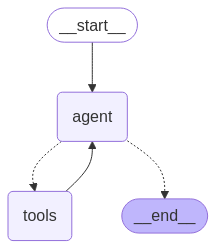

In [43]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [44]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

In [45]:
config = {"configurable": {"thread_id": "1"},"recursive_limit" : 12}

inputs =  {"messages" : [
        {
            "role": "user",
            "content": user_msg
        }
    ]}

#print_stream(graph.stream(inputs, config=config, stream_mode="values"))

#stream = graph.stream(inputs, config=config, stream_mode="values")

In [47]:
output = graph.invoke(input=inputs, config=config)

<class 'method'>
query_results entered func search_results
category ('news_queries', 'news_searches')
Debug: No valid date or year found for https://vegas.insuretechconnect.com/, defaulting to 2024
Debug: Found date 2024-09-29 00:00:00+00:00 in snippet for https://www2.deloitte.com/us/en/insights/industry/financial-services/financial-services-industry-outlooks/insurance-industry-outlook.html
Debug: Found date 2025-02-11 00:00:00+00:00 in snippet for https://www.insurance.ca.gov/0400-news/0100-press-releases/2025/release015-2025.cfm
Debug: Found date 2024-11-19 00:00:00+00:00 in snippet for https://www.mckinsey.com/industries/financial-services/our-insights/global-insurance-report
Debug: No valid date or year found for https://www.atom-insurance.co/, defaulting to 2024
Debug: Found date 2022-09-06 17:27:01-07:00 in metadata for https://rss.feedspot.com/insurtech_rss_feeds/
Debug: No valid date or year found for http://rss-insurance.com/, defaulting to 2024
Debug: Found date 2021-04-21 0

In [48]:
last_tool_message = next(
    (msg for msg in reversed(output["messages"]) if msg.type == "tool"),
    None
)

print(last_tool_message)

content='{"topic": "insurtech", "news": [{"doc_type": "text/html", "link": "https://www.insurance.ca.gov/0400-news/0100-press-releases/2025/release015-2025.cfm", "published_date": "2025-02-11T00:00:00+00:00", "snippet": "Feb 11, 2025 ... Insurance News Overview / Press Releases / 2025 Press Releases ... Insurance Strategy I finalized last year. \\u201cWe must rebuild stronger\\u00a0...", "title": "Commissioner Lara takes action to ensure FAIR Plan can continue ...", "full_content": "Commissioner Lara takes action to ensure FAIR Plan can continue paying consumer claims after the Southern California wildfires Skip to Main Content Search this site: Insurance News Overview / Press Releases / 2025 Press Releases / Commissioner Lara takes action to ensure FAIR Plan can continue paying consumer claims after the Southern California wildfires Commissioner Lara takes action to ensure FAIR Plan can continue paying consumer claims after the Southern California wildfires News: 2025 Press Release Fo

In [ ]:
last_tool_message

In [10]:
class RefineContent(BaseModel):
    topic: str
    news: Optional[List[Dict[str, Any]]] = None
    reports: Optional[List[Dict[str, Any]]] = None 

In [49]:
def get_final_content(scraped_results):
    """This function tool receives the input from scrape_content, and outputs a refined set of insurance news and reports data"""

    #scraped_results = scraped_results.model_validate_json()

    #scraped_results = json.dumps(scraped_results, indent=2)

    refine_prompt = """
You are an expert insurance news analyst. Process a JSON input with `topic`, `news`, and `reports` arrays to generate refined results for each item in `news` and `reports`.
Strictly follow the instructions below:

**Input Structure**:
- `topic`: String theme as it is.
- `news`: Array of objects with `link` (URL), `title`, `published_date`, `snippet`,`source`,`summary`,`tags`
- `reports`: Array of objects with same fields as `news`.

**Output Fields** (per item):
- `date`: Extract a more accurate date directly got from the `snippet` and `title`. If the right date cannot be obtained just provide the year or YYYY-MM.
- `source`: Source of the content as understood.
- `link`: Exact input `link`.
- `title`: Concise, crisp, clear title based on `title` or `snippet`.
- `summary`: Summarize `snippet` or `full_content` in ≤5 lines (~70-100 words).
- `tags`: Keywords from content.
- `topic`: Input `topic` value.

**STRICT Instructions**:
- Process ALL items in `news` and `reports`. Keep same number of elements as input. For example, if `news` has 5 objects, maintain the same number.
- Output a JSON dictionary with `topic`, `news`, and `reports` keys.
- Exclude `full_content`.
- Ensure valid JSON, escaping special characters.

Generate valid JSON output, retaining input structure and EVERY item.

<input>
{scraped_results}
</input>
""" 
    
    prompt = PromptTemplate(
        input_variables = ['scraped_results'],
        template=refine_prompt
    )
    
    
    formatted_prompt = prompt.format(scraped_results=scraped_results)
    
    # Define the LLM
    int_mod = "google/gemma-3-27b-it:free"
    
    llm = ChatOpenAI(model=int_mod,
                     base_url="https://openrouter.ai/api/v1",
                     api_key=openrouter_api_key,
                     temperature=0.2
                     )
    
    
    model_with_structure = llm.with_structured_output(RefineContent, method="json_mode")
    
    # Invoke the model to produce structured output that matches the schema
    final_results = model_with_structure.invoke(input=formatted_prompt)

    return final_results.model_dump_json()

In [50]:
final_contents = get_final_content(last_tool_message)
final_contents

'{"topic":"insurtech","news":[{"date":"2025-02-11","source":"Insurance.ca.gov","link":"https://www.insurance.ca.gov/0400-news/0100-press-releases/2025/release015-2025.cfm","title":"Commissioner Lara Ensures FAIR Plan Continues Paying Claims","summary":"California Insurance Commissioner Ricardo Lara took action to ensure the FAIR Plan can continue paying claims to Southern California wildfire survivors. The FAIR Plan requested $1 billion in additional funds and released claims data.  Commissioner Lara approved the funding, consistent with his Sustainable Insurance Strategy. Key actions include hiring additional staff, utilizing available funds, and protecting consumers from assessment costs.","tags":["FAIR Plan","wildfires","insurance","California","Commissioner Lara","claims"]},{"date":"2025-02-05","source":"Florida Governor\'s Office","link":"https://www.flgov.com/eog/news/press/2025/governor-ron-desantis-announces-rate-reductions-miami-dade-county-auto-insurance","title":"DeSantis An

In [43]:
# Final refined data for rendering - Topic : Climate Risk
render_content = json.loads(final_contents)

with open("climate_risk.json", 'w', encoding='utf-8') as f:
        json.dump(render_content, f, indent=2, ensure_ascii=False)
    

In [51]:
# Final refined data for rendering - Topic : Insurtech
render_content = json.loads(final_contents)

with open("insurtech.json", 'w', encoding='utf-8') as f:
        json.dump(render_content, f, indent=2, ensure_ascii=False)

In [57]:
# Merge data

# Load individual JSON files
with open("climate_risk.json") as f1, open("insurtech.json") as f2:
    cr = json.load(f1)
    it = json.load(f2)

# Combine them as a list
combined = [cr, it]

# Save the combined list to a new file
with open("combined_renders.json", "w") as f_out:
    json.dump(combined, f_out, indent=2)


## UI Component

In [78]:
%%writefile insurance_dashboard.py
import json
import streamlit as st
from collections import defaultdict
import uuid
import sys


def main():
    
    # Parse custom CLI argument
    json_path = None
    for arg in sys.argv:
        if arg.endswith('.json'):
            json_path = arg
            break

    if not json_path:
        st.error("No JSON file provided!")
        st.stop()
    
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    # Check for empty data
    if not data:
        st.warning("No data available for topics, news articles, or research papers.")
    
    # Placeholder functions with caching
    @st.cache_data
    def get_all_tags(data):
        """Extract unique tags from all topics, news, and reports."""
        try:
            all_tags = set()
            for topic_data in data:
                for news_item in topic_data.get("news", []):
                    all_tags.update(news_item.get("tags", []))
                for report_item in topic_data.get("reports", []):
                    all_tags.update(report_item.get("tags", []))
            return sorted(list(all_tags)) if all_tags else ["No tags available"]
        except Exception as e:
            st.error(f"Error retrieving tags: {e}")
            return ["No tags available"]
    
    @st.cache_data
    def filter_by_tag(items, tag):
        """Filter items by a specific tag."""
        try:
            if tag == "No tags available":
                return []
            return [item for item in items if tag in item.get("tags", [])]
        except Exception as e:
            st.error(f"Error filtering by tag: {e}")
            return []
    
    # Streamlit UI
    st.title("Insurance News & Report Dashboard")
    
    # Sidebar styling and tag selection
    st.markdown(
        """
        <style>
        [data-testid="stSidebar"] { background-color: #f0f4f8; }
        .bullet-point { margin-left: 20px; font-size: 16px; line-height: 1.5; }
        </style>
        """,
        unsafe_allow_html=True
    )
    st.sidebar.header("Filter by Tag")
    all_tags = get_all_tags(data)
    selected_tag = st.sidebar.selectbox("Select a tag", all_tags, index=0, key="tag_select")
    
    # Function to format text as bullet points with tick symbol
    def format_as_bullets(text):
        """Convert text to bullet points, splitting by sentences if needed."""
        if not text:
            return ["No content available"]
        if isinstance(text, list):
            return text
        # Split by periods, remove empty strings, and strip whitespace
        sentences = [s.strip() for s in text.split(".") if s.strip()]
        return sentences if sentences else [text]
    
    # Display topics and their filtered content
    for topic_data in data:
        topic = topic_data.get("topic", "Unknown Topic")
        st.header(topic)
        
        # Display filtered News Articles
        with st.expander(f"News Articles Tagged: {selected_tag}", expanded=True):
            filtered_news = filter_by_tag(topic_data.get("news", []), selected_tag)
            if filtered_news:
                # Group articles by title
                articles_by_title = defaultdict(list)
                for article in filtered_news:
                    articles_by_title[article["title"]].append(article)
                
                # Pagination
                news_per_page = 5
                page_number = st.number_input(
                    f"News Page for {topic}",
                    min_value=1,
                    value=1,
                    step=1,
                    key=f"news_page_{topic}_{uuid.uuid4()}"
                )
                start_idx = (page_number - 1) * news_per_page
                end_idx = start_idx + news_per_page
                
                # Get paginated titles
                title_list = list(articles_by_title.keys())
                paginated_titles = title_list[start_idx:end_idx]
                
                for title in paginated_titles:
                    st.subheader(title)
                    for article in articles_by_title[title]:
                        st.caption(f"{article.get('source', 'Unknown')} | {article.get('date', 'Unknown')}")
                        # Display summary as bullet points with tick symbol
                        bullets = format_as_bullets(article.get("summary", ""))
                        for bullet in bullets:
                            st.markdown(f'<div class="bullet-point">✓ {bullet}</div>', unsafe_allow_html=True)
                        st.markdown("---")
                st.write(f"Showing {start_idx + 1}-{min(end_idx, len(title_list))} of {len(title_list)} unique article titles")
            else:
                st.write("No news articles match this tag.")
        
        # Display filtered Research Papers
        with st.expander(f"Research Papers Tagged: {selected_tag}", expanded=True):
            filtered_research = filter_by_tag(topic_data.get("reports", []), selected_tag)
            if filtered_research:
                # Pagination
                research_per_page = 5
                page_number = st.number_input(
                    f"Research Page for {topic}",
                    min_value=1,
                    value=1,
                    step=1,
                    key=f"research_page_{topic}_{uuid.uuid4()}"
                )
                start_idx = (page_number - 1) * research_per_page
                end_idx = start_idx + research_per_page
                paginated_research = filtered_research[start_idx:end_idx]
                
                for paper in paginated_research:
                    st.subheader(paper["title"])
                    st.caption(f"{paper.get('authors', 'Unknown')} | {paper.get('date', 'Unknown')}")
                    # Display abstract as bullet points with tick symbol
                    bullets = format_as_bullets(paper.get("abstract", ""))
                    for bullet in bullets:
                        st.markdown(f'<div class="bullet-point">✓ {bullet}</div>', unsafe_allow_html=True)
                    st.markdown("---")
                st.write(f"Showing {start_idx + 1}-{min(end_idx, len(filtered_research))} of {len(filtered_research)} papers")
            else:
                st.write("No research papers match this tag.")
    
    # Sidebar About section
    st.sidebar.markdown("---")
    st.sidebar.header("About")
    st.sidebar.info(
        "This dashboard integrates news and academic research on climate risk insurance and insurtech."
        "Select a tag to see related items from both news and research reports."
    )
    
if __name__ == "__main__":
    main()


Overwriting insurance_dashboard.py


In [62]:
#!python insurance_dashboard.py combined_renders.json

### Using NGrok to tunnel in Streamlit dashboard

In [63]:
!curl -sSL https://ngrok-agent.s3.amazonaws.com/ngrok.asc \
  | sudo tee /etc/apt/trusted.gpg.d/ngrok.asc >/dev/null \
  && echo "deb https://ngrok-agent.s3.amazonaws.com buster main" \
  | sudo tee /etc/apt/sources.list.d/ngrok.list \
  && sudo apt update \
  && sudo apt install ngrok

deb https://ngrok-agent.s3.amazonaws.com buster main
Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease                         
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]           
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]        
Get:7 https://ngrok-agent.s3.amazonaws.com buster InRelease [20.3 kB]          
Get:8 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [75.2 kB]
Get:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]3m
Get:10 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,243 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:12 https://dev

In [64]:
!ngrok config add-authtoken <Ngrok auth token>

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [88]:
get_ipython().system_raw('ngrok http 8501 &')

In [86]:
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    'import sys, json; print("Execute the next cell and the go to the following URL: " +json.load(sys.stdin)["tunnels"][0]["public_url"])'

Execute the next cell and the go to the following URL: https://0157-35-227-100-191.ngrok-free.app


In [87]:
!streamlit run ./insurance_dashboard.py combined_renders.json




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.19.2.2:8501
  External URL: http://35.227.100.191:8501

^C
  Stopping...
